# Identifying Entities in Healthcare Data

## Workspace set up: Import and Install useful packages.

In [1]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

model = spacy.load("en_core_web_sm")

## Data Preprocessing

The dataset provided is in the form of one word per line. Let's understand the format of data below:
- Suppose there are *x* words in a sentence, then there will be *x* continuous lines with one word in each line. 
- Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**

### Construct the proper sentences from individual words and print the 5 sentences.

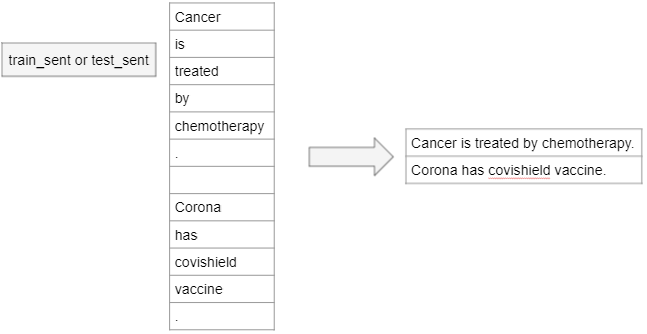

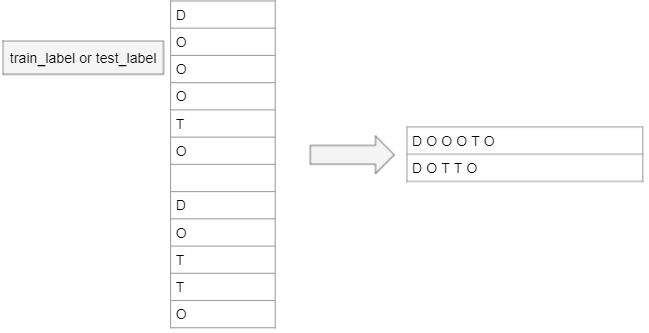

In [2]:
class my_dictionary(dict):
    """Class to Create & perform Dictionary Functions with ease"""

    # __init__ function
    def __init__(self):
        super().__init__()
        self = dict()

    # Function to add key:value
    def add(self, key, value):
        self[key] = value


def process_data_file(filename):
    lst = []
    with open(filename) as f:
        for w in f.readlines():
            lst.append(w.strip())
    
    transformed_lst = " ".join(lst).split("  ")
    return transformed_lst

In [3]:
train_sent = process_data_file("train_sent")
train_label = process_data_file("train_label")
test_sent = process_data_file("test_sent")
test_label = process_data_file("test_label")

In [4]:
for i in range(5):
    print("{}.\nSentence: {}\nLabel: {}\n".format((i+1), train_sent[i], train_label[i]))

1.
Sentence: All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Label: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

2.
Sentence: The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Label: O O O O O O O O O O O O O O O O O O O O O O O O O

3.
Sentence: Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Label: O O O O O O O O O O O O O O O

4.
Sentence: The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) , and the `` corrected '' primary rate was 9.6 % ( 190 of 1975 )
Label: O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O

5.
Sentence: Arrest of dilation was the most common indication in both ``

### Count the number of sentences in the processed train and test dataset 

In [5]:
print("Number of Sentences:\n\tIn Processed Train Dataset - {}\n\tIn Processed Test Dataset - {}".format(len(train_sent), 
                                                                                                     len(test_sent)))

Number of Sentences:
	In Processed Train Dataset - 2599
	In Processed Test Dataset - 1056


### Count the number of lines of labels in the processed train and test dataset.

In [6]:
print("Number of Lines of Labels:\n\tIn Processed Train Dataset - {}\n\tIn Processed Test Dataset - {}".format(
    len(train_label), len(test_label)))

Number of Lines of Labels:
	In Processed Train Dataset - 2599
	In Processed Test Dataset - 1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging. 

### Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [7]:
token_freq = my_dictionary()

all_sentences = train_sent + test_sent

for s in tqdm(all_sentences):
    for w in s.split():
        for doc in model(w):
            if doc.pos_ == "NOUN" or doc.pos_ == "PROPN":
                token_freq.add(doc.text, (token_freq.get(doc.text, 0) + 1))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3655/3655 [09:24<00:00,  6.47it/s]


### Print the top 25 most common tokens with NOUN or PROPN PoS tags

In [8]:
token_freq_sorted = Counter(token_freq)
print(token_freq_sorted.most_common(25))

[('patients', 492), ('treatment', 281), ('cancer', 200), ('therapy', 175), ('disease', 143), ('cell', 140), ('lung', 116), ('group', 94), ('gene', 88), ('chemotherapy', 88), ('effects', 85), ('results', 79), ('women', 77), ('patient', 75), ('TO_SEE', 75), ('risk', 71), ('cases', 71), ('surgery', 71), ('analysis', 70), ('rate', 67), ('human', 67), ('response', 66), ('survival', 65), ('effect', 64), ('children', 64)]


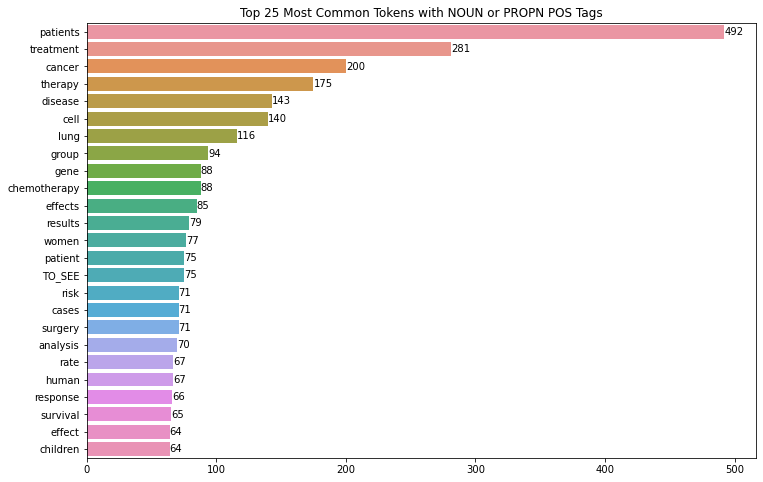

In [9]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(y=list(dict(token_freq_sorted.most_common(25)).keys()),
                 x=list(dict(token_freq_sorted.most_common(25)).values()))

for i in ax.containers:
    ax.bar_label(i)

plt.title("Top 25 Most Common Tokens with NOUN or PROPN POS Tags")
plt.show()

## Defining features for CRF

Following Features are defined to Train a Custom CRF to identify `Diseases (D)` & `Treatments (T)`.
- Each word in `Lower Case`.
- Extracting: <br>
    - Last 3 Characters<br>
    - Last 2 Characters<br>
- `Number of Characters` in the current & the previous words respectively.
- If the word is all in `Upper Case`. (True/False)
- If the word is a `Number/Digit`. (True/False)
- If the word `starts` with an `Upper Case` Character. (True/False)
- `PoS Tag` for each word.
- Marks the `Beginning (BEG)` & the `End (END)` words of a sentence correctly in the form of features.

In [10]:
def getFeaturesForOneWord(sentence, pos):
    word = sentence[pos]
    doc = model(word)
    for tok in doc:
        word_pos_tag = tok.pos_
    
    features = [
        "word.lower = " + word.lower(),
        "word.length = %s" % len(word.strip()),
        "word[-3:] = " + word[-3:],
        "word[-2:] = " + word[-2:],
        "word.isupper = %s" % word.isupper(),
        "word.isdigit = %s" % word.isdigit(),
        "word.startsWithCapital = %s" % word[0].isupper(),
        "word.pos = " + word_pos_tag
    ]
    
    if (pos > 0):
        prev_word = sentence[pos - 1]
        prev_doc = model(prev_word)
        for tok in doc:
            prev_word_pos_tag = tok.pos_
        features.extend([
        "prev_word.lower = " + prev_word.lower(),
        "prev_word.length = %s" % len(prev_word.strip()),
        "prev_word.isupper = %s" % prev_word.isupper(),
        "prev_word.isdigit = %s" % prev_word.isdigit(),
        "prev_word.startsWithCapital = %s" % prev_word[0].isupper(),
        "prev_word.pos = " + prev_word_pos_tag
        ])
    else:
        features.append("BEG")
    
    if (pos == (len(sentence) - 1)):
        features.append("END")
    return features

## Getting the features

### Write a code/function to get the features for a sentence

In [11]:
def getFeaturesForOneSentence(sentence):
    sentence_list = sentence.split()
    return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

### Write a code/function to get the labels of a sentence

In [12]:
def getLabelsInListForOneSentence(labels):
    return labels.split()

## Define input and target variables

Correctly computing X and Y sequence matrices for training and test data.

Check that both sentences and labels are processed

### Define the features' values for each sentence as input variable  for CRF model in test and the train dataset 

In [13]:
%%time
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_sent]
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_sent]

CPU times: total: 13min 48s
Wall time: 13min 59s


### Define the labels as the target variable for test and the train dataset

In [14]:
%%time
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_label]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label]

CPU times: total: 15.6 ms
Wall time: 15.6 ms


## Build the CRF Model

In [15]:
%%time
try:
    crf = sklearn_crfsuite.CRF(algorithm="l2sgd", max_iterations=200, all_possible_transitions=True, c2=0.1)
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

CPU times: total: 8.25 s
Wall time: 8.3 s


## Evaluation

### Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [16]:
Y_pred = crf.predict(X_test)

### F1 Score using the Actual Labels & the Predicted Labels of the Train Dataset.

In [17]:
Y_train_pred = crf.predict(X_train)
print("F1 Score for Train Dataset: " + str(round(metrics.flat_f1_score(Y_train, Y_train_pred, average='weighted')*100,
                                                 2)) + "%")

F1 Score for Train Dataset: 96.46%


### F1 Score using the Actual Labels & the Predicted Labels of the Test Dataset.

In [18]:
print("F1 Score for Test Dataset: " + str(round(metrics.flat_f1_score(Y_test, Y_pred, average='weighted')*100, 2)) + "%")

F1 Score for Test Dataset: 92.02%


## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.

### Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

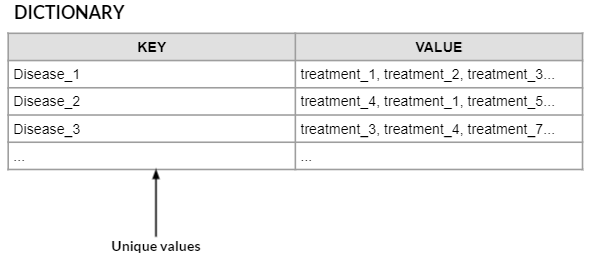

### Assumptions made on this Dataset:
- We are assuming that if there is a disease in the sentence, then the treatment mentioned in that sentence can be assumed to be the treatment for that disease.
- The same treatment can work for different diseases.

In [19]:
treatments_for_diseases = my_dictionary()

for a in range(len(Y_pred)):
    disease = ""
    treatment = ""
    for b in range(len(Y_pred[a])):
        if Y_pred[a][b] == "D":
            disease_name = list(test_sent[a].split())[b]
            disease += disease_name + " "
            continue
        elif Y_pred[a][b] == "T":
            treatment_name = list(test_sent[a].split())[b]
            treatment += treatment_name + " "
            continue
        else:
            continue
    
    disease = disease.strip()
    treatment = treatment.strip()
    
    if treatment != "" and disease != "":
        if disease not in list(treatments_for_diseases.keys()):
            treatments_for_diseases.add(disease, [treatment])
        else:
            treatments_for_diseases[disease] = treatments_for_diseases.get(disease) + [treatment]

In [20]:
print("Overall, we have found the Treatments Mapping for {} Diseases.".format(len(treatments_for_diseases)))

Overall, we have found the Treatments Mapping for 177 Diseases.


### Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [21]:
treatments_for_diseases.get("hereditary retinoblastoma")

['radiotherapy']